In [2]:
import pandas as pd

match_df = pd.read_csv('../my_data/elo_pbp_with_surface_10_15.csv')
train_ids = set(match_df[match_df['match_year']<2014]['match_id'])
test_ids = set(match_df[match_df['match_year'].isin([2014])]['match_id'])

In [ ]:
# TO DO: 1) combine this with probability models ipynb

# 4) try KNN clustering, with distance hierarchy from set,game,point clearly set; this would take
# a lot of hyperparameter tuning, otherwise might be a good idea

# when testing just score features, it would make sense to use all of the pbp data, from challenger
# matches, etc

In [8]:
## TO DO: try adding interaction terms, for example sets_won/sets_lost and service breaks

# set up cross validation loop

## set up model assessment loop for just a few models
## (to do this, you have to read the docs on NN, etc.)

## then, try these out with a neural net etc because there is probably a non-linear relationship
## (ie you gain more win-probability from 3 games needed to 1 vs 5 to 3)

## From an ML approach, it seems like only Logistic Regression and maybe Neural Net are feasible.
## still, the issue lies in these being naive to score (adding a point,game, or set has the same
## effect, regardless of where we are in the match)

import numpy as np
import math
import time
import pandas as pd
from helper_functions import cross_validate
from sklearn import linear_model
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

df_pred = pd.read_csv('../my_data/feature_df_pbp3_9_6_alphas.csv')
val_df,test_df = df_pred[df_pred['match_id'].isin(train_ids)],df_pred[df_pred['match_id'].isin(test_ids)]

In [16]:
#c = int(max(df_pred['match_id'])*.8)

In [18]:
from sklearn.metrics import log_loss, accuracy_score

scores = ['sets_0','sets_1','games_0','games_1','points_0','points_1']
break_feats = [u'up_break_point', u'down_break_point', u'break_adv']
point_rates = [u'sv_points_pct_0', u'sv_points_pct_1']
cols = ['lead_margin','elo_diff','s_elo_diff']+scores+break_feats+point_rates

# for MLP, I would consider grid search over alpha, batch_size, and hidden_layer_sizes...
models = [linear_model.LogisticRegression(fit_intercept = True)]
model_hparams = {'LogisticRegression':{'C':[100]}}
baseline = ['lead_margin','elo_diff','s_elo_diff']
column_lists = [baseline,scores,baseline+scores,cols]

for columns in column_lists:
    print columns
    Xtrain, ytrain = val_df[columns],val_df['winner']
    Xtest, ytest = test_df[columns],test_df['winner']
    for clf in models:
        model_name = clf.__str__().split('(')[0]
        print model_name
        setattr(clf,'C',100)
#         best_hyper_p = cross_validate(val_df,clf,columns,'winner',model_hparams[model_name],n_splits=5)
#         for key in best_hyper_p.keys():
#             setattr(clf,key,best_hyper_p[key])
        clf.fit(Xtrain,ytrain)

        probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
        train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
        train_accuracy = clf.score(Xtrain, ytrain)
        test_accuracy = clf.score(Xtest, ytest)  
        print train_loss, test_loss
        print train_accuracy, test_accuracy
    print '\n'

['lead_margin', 'elo_diff', 's_elo_diff']
LogisticRegression
0.491891056277 0.503387078421
0.759882522483 0.753617057595


['sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1']
LogisticRegression
0.529695188621 0.539498184303
0.724838407608 0.715184777002


['lead_margin', 'elo_diff', 's_elo_diff', 'sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1']
LogisticRegression
0.476664055944 0.488136006185
0.767241588987 0.762300222274


['lead_margin', 'elo_diff', 's_elo_diff', 'sets_0', 'sets_1', 'games_0', 'games_1', 'points_0', 'points_1', u'up_break_point', u'down_break_point', u'break_adv', u'sv_points_pct_0', u'sv_points_pct_1']
LogisticRegression
0.475064879129 0.486292687994
0.768203846598 0.763561878681




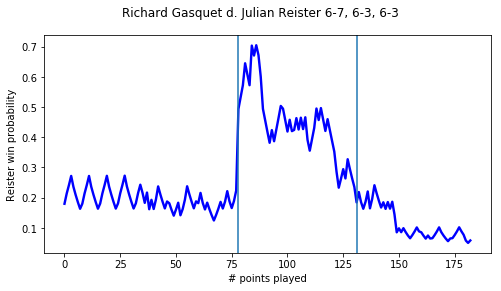

In [56]:
# graphically, try to compare different probabilities of different models
import matplotlib.pyplot as plt
%matplotlib inline

probs = np.concatenate((probs_train[:,1],probs_test[:,1]))
df_pred['prob4'] = probs

match1 = df_pred[df_pred['match_id']==1]
m1_probs = match1['prob4']
set_lengths = [len(a) for a in list(match1['score'])[-1].replace(';','').replace('/','').split('.')]
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),m1_probs,'b-',linewidth=2.4)
fig.suptitle('Richard Gasquet d. Julian Reister 6-7, 6-3, 6-3')
ax.set_ylabel('Reister win probability')
ax.set_xlabel('# points played')
ax.axvline(set_lengths[0]); ax.axvline(sum(set_lengths[:2]))
plt.savefig('gasquet_reister_9_6_all_features')
fig.show()

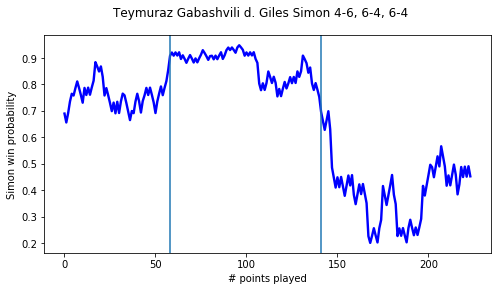

In [57]:
probs = np.concatenate((probs_train[:,1],probs_test[:,1]))
df_pred['prob4'] = probs

match1 = df_pred[df_pred['match_id']==6310]
m1_probs = match1['prob4']
set_lengths = [len(a) for a in list(match1['score'])[-1].replace(';','').replace('/','').split('.')]
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(m1_probs)),m1_probs,'b-',linewidth=2.4)
fig.suptitle('Teymuraz Gabashvili d. Giles Simon 4-6, 6-4, 6-4')
ax.set_ylabel('Simon win probability')
ax.set_xlabel('# points played')
ax.axvline(set_lengths[0]); ax.axvline(sum(set_lengths[:2]))
plt.savefig('simon_gabashvili_9_6_all_features')
fig.show()

In [ ]:
# current feedback is that the drop in probability is probably a little too great from 
# end of first set to beginning of second
# this is something that should eventually be fixed with markov/hierarchical models

In [ ]:
cols1 = ['elo_diff']
cols2 = ['elo_diff','set_diff']
cols3 = ['elo_diff','set_diff','game_diff']
cols = ['elo_diff','set_diff','game_diff','point_diff']

# either change do-classify to work for all classifiers or use this code
# repeat this for random forest, neural net, adaboost, etc
print 'features: ', cols
clf = ensemble.RandomForestClassifier(n_estimators=10,max_features=None,oob_score=True)
clf=clf.fit(Xtrain, ytrain)
probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
train_accuracy = clf.oob_score_
#test_accuracy = clf.oob_score(Xtest, ytest)
print "############# based on standard predict ################"
print "Accuracy on training data: %0.2f" % (train_accuracy)
print "Log Loss on training data: %0.2f" % (train_loss)
#print "Accuracy on test data:     %0.2f" % (test_accuracy)
print "Log Loss on test data:     %0.2f" % (test_loss)

In [ ]:
# next, 1) compare avg log_loss for prediction with sets, games, and points as features
# 2) then try keeping track of service breaks as a feature
# 3) the next step: does order matter?
# see your notes for next steps

probs = clflogELO.predict_proba(Xtest)
log_loss(ytest,probs,labels=[0,1])

In [7]:
# features for number of sets away from the match
# number of games away from the set
# number of points away from set
# then observe the gasquet match graph and see if this fixes anything
# df_pred['p0_sets_away'] = [2-int(a[1]) for a in df_pred['set_score']]
# df_pred['p1_sets_away'] = [2-int(a[4]) for a in df_pred['set_score']]
# df_pred['p0_games_away'] = [6-int(a[1]) if int(a[4])<5 else 7-int(a[1]) for a in df_pred['game_score']]
# df_pred['p1_games_away'] = [6-int(a[4]) if int(a[1])<5 else 7-int(a[4]) for a in df_pred['game_score']]

# points away...

#####################

# form train and test as 80-20 split; keeps matches in their entirety separate from one another
# takes about 40 seconds

# train_ids = np.random.choice(ids,size=int(.8*len(ids)),replace=False)
# train_dict = dict(zip(train_ids,[1]*len(train_ids)))
# df_pred['train'] = [1 if df_pred['match_id'][i] in train_dict else 0 for i in xrange(len(df_pred))]
# mask = df_pred['train']
# mask = mask==1

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# # feed in validation set, return model with most favorable hyper-parameters
# h_param = {'C':[.0001,.001,.01,.1,1,10,100,1000]}
# def cross_validate(X,Y,clf,hyper_parameters):
#     print 'fitting model...'
#     skf = StratifiedKFold(n_splits=5)
#     for train_index,test_index in skf.split(X,Y):
#         X_train,X_test = X[train_index],X[test_index]
#         Y_train,Y_test = Y[train_index],Y[test_index]

# to do: set up another notebook with solely cross-validation framework and model testing...
# test hyperparameters for these sklearn models

#set_features = ['0','1','01','10']
cols = []
scores = ['sets_0','sets_1','games_0','games_1','points_0','points_1']
break_feats = [u'up_break_point', u'down_break_point', u'break_adv']
point_rates = [u'sv_points_pct_0', u'sv_points_pct_1',u'tp_0',u'tp_1']

#cols.append(['in_lead'])
#cols.append(['in_lead','elo_diff'])
#cols.append(['elo_diff']+scores+point_rates)
cols.append(['elo_diff','sets_0','sets_1','points_0','points_1','break_adv']+point_rates)
cols.append(['in_lead','elo_diff']+scores+break_feats+point_rates)

#models.append(ensemble.RandomForestClassifier(n_estimators=200,max_features=None,oob_score=True))

# models = [linear_model.LogisticRegression(fit_intercept = True)]

# for col in cols:
#     print 'cols: ',col
#     for model in models:
#         Xtrain = df_pred[mask][col]; Xtest = df_pred[~mask][col]
#         clf = model
#         clf.fit(Xtrain,ytrain)
        
#         # cross-validate the model, fitting hyper-params on training set
#         #clf = cross_validate(Xtrain,ytrain,model)

#         probs_train,probs_test = clf.predict_proba(Xtrain),clf.predict_proba(Xtest)
#         train_loss, test_loss = log_loss(ytrain,probs_train,labels=[0,1]),log_loss(ytest,probs_test,labels=[0,1])
#         train_accuracy = clf.score(Xtrain, ytrain)
#         test_accuracy = clf.score(Xtest, ytest)  
#         print 'classifier: ', str(clf).split("(")[0]
#         print train_loss, test_loss
#         print train_accuracy, test_accuracy
#     print '\n'

In [ ]:
# match_df.loc[7756][['sum','elo_prob']]
# match_df.loc[7253][['sum','elo_prob']]
# match_df['sum'] = match_df['p0_s_kls_JS'] + match_df['p1_s_kls_JS']
# sub1 = match_df[match_df['sum']>1.50]
# sub1 = sub1[(sub1['elo_prob']>.47) & (sub1['elo_prob']<.48)]
# sub1[['sum','elo_prob','score','p0_name','p1_name','winner']]